<a href="https://colab.research.google.com/github/tugberksentepe/Optimization-Algorithm-Project/blob/main/ACO_Project_HeartDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 1, Best Fitness: 0.5608908305966666
Iteration 2, Best Fitness: 0.7622219406421724
Iteration 3, Best Fitness: 0.8308206080731074
Iteration 4, Best Fitness: 0.8584832492225312
Iteration 5, Best Fitness: 0.8650699316025584
Iteration 6, Best Fitness: 0.8669820842402605
Iteration 7, Best Fitness: 0.8666932182725408
Iteration 8, Best Fitness: 0.872980948454185
Iteration 9, Best Fitness: 0.8704971509406904
Iteration 10, Best Fitness: 0.8645081961164941
Iteration 11, Best Fitness: 0.8711120298722307
Iteration 12, Best Fitness: 0.8700226706265273
Iteration 13, Best Fitness: 0.8689112708923603
Iteration 14, Best Fitness: 0.8633584609150566
Iteration 15, Best Fitness: 0.8663286177956654
Iteration 16, Best Fitness: 0.872761557515315
Iteration 17, Best Fitness: 0.8698052283503531
Iteration 18, Best Fitness: 0.8632062637920255
Iteration 19, Best Fitness: 0.8721627179918858
Iteration 20, Best Fitness: 0.8669119466027869
Iteration 21, Best Fitness: 0.8680489088255142
Iteration 22, Best Fitne

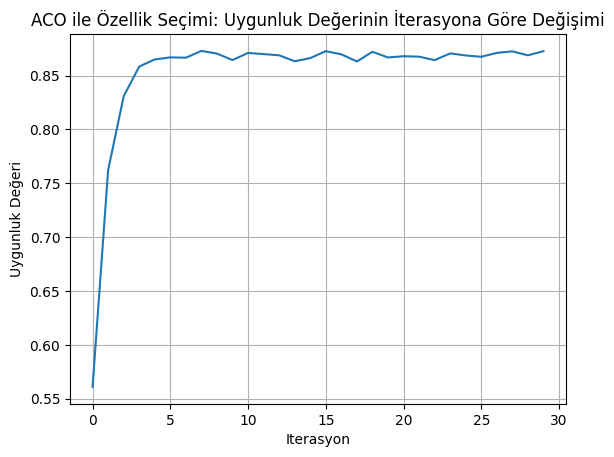

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Adım 1: Veri Setinin Yüklenmesi ve Hazırlanması
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
data = pd.read_csv(url, names=column_names)

# Veriyi temizleyelim ( '?' değerlerini NaN ile değiştirip sonra bu satırları çıkaralım)
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)

# Özellikler ve hedef değişkeni ayıralım
X = data.drop('num', axis=1)
y = data['num']
y = y.apply(lambda x: 1 if x > 0 else 0)  # 'num' sütununu binary sınıflandırma için 0 ve 1 olarak değiştiriyoruz

# Eğitim ve test setlerine ayıralım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adım 2: Uygunluk Fonksiyonunun Tanımlanması
def fitness_function(predictions, y_true):
    return accuracy_score(y_true, predictions)

# Adım 3: ACO Algoritmasının Uygulanması
# ACO Parametreleri
num_ants = 10
num_iterations = 30
pheromone = np.ones(X_train.shape[1])  # Başlangıçta tüm özellikler için pheromone seviyesi 1 olarak başlar
alpha = 0.1  # Pheromon güncelleme katsayısı
beta = 2  # Özellik seçimi için feromon güncelleme katsayısı

# ACO algoritması
best_fitness_values = []  # En iyi uygunluk değerlerini kaydetmek için liste
for iteration in range(num_iterations):
    for ant in range(num_ants):
        probabilities = pheromone / np.sum(pheromone)  # Her özelliğin seçilme olasılıkları
        selected_features = np.random.choice(X_train.shape[1], size=X_train.shape[1], replace=False, p=probabilities)

        # Seçilen özelliklerle bir sınıflandırıcı eğit
        rf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt')
        rf.fit(X_train.iloc[:, selected_features], y_train)
        predictions = rf.predict(X_test.iloc[:, selected_features])

        # Uygunluk fonksiyonunu hesapla
        fitness = 1 - fitness_function(predictions, y_test)  # Minimizasyon için uygunluk değeri ters çevrilir

        # Pheromone güncellemesi
        pheromone[selected_features] = (1 - alpha) * pheromone[selected_features] + alpha * fitness

    best_fitness_values.append(1 - pheromone.min())  # Her iterasyonda en iyi uygunluk değerini kaydet

    print(f"Iteration {iteration + 1}, Best Fitness: {1 - pheromone.min()}")

# En iyi çözümün değerlendirilmesi
selected_feature_indices = np.where(pheromone == pheromone.min())[0]
selected_feature_names = X.columns[selected_feature_indices].tolist()  # Seçilen özelliklerin isimleri
print(f"Best Solution Features: {selected_feature_names}")
final_rf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt')
final_rf.fit(X_train.iloc[:, selected_feature_indices], y_train)
final_predictions = final_rf.predict(X_test.iloc[:, selected_feature_indices])
final_accuracy = accuracy_score(y_test, final_predictions)
print(f"Final Model Accuracy: {final_accuracy}")

# Adım 4: Hiperparametre Optimizasyonu
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, max_features='sqrt'), param_grid=param_grid, cv=5)
grid_search.fit(X_train.iloc[:, selected_feature_indices], y_train)

print(f"Best Parameters: {grid_search.best_params_}")

# En iyi parametrelerle final modelin eğitilmesi
best_rf = grid_search.best_estimator_
best_rf.fit(X_train.iloc[:, selected_feature_indices], y_train)
best_predictions = best_rf.predict(X_test.iloc[:, selected_feature_indices])
best_accuracy = accuracy_score(y_test, best_predictions)
print(f"Best Model Accuracy with Hyperparameter Tuning: {best_accuracy}")

# Adım 5: Çapraz Doğrulama ile Model Performansını Değerlendirme
scores = cross_val_score(final_rf, X_train.iloc[:, selected_feature_indices], y_train, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

# En iyi uygunluk değerinin nasıl değiştiğini gösteren bir grafik oluşturma
plt.plot(best_fitness_values)
plt.xlabel('Iterasyon')
plt.ylabel('Uygunluk Değeri')
plt.title('ACO ile Özellik Seçimi: Uygunluk Değerinin İterasyona Göre Değişimi')
plt.grid(True)
plt.show()